In [9]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import os
if not os.path.exists('plots/'):
    os.mkdir('plots')
import pickle
from six.moves import cPickle
from collections import defaultdict, OrderedDict

import numpy as np
import keras
import tf_keras.backend as K
from IPython.display import clear_output

import kde
import simplebinmi
import matrixRenyi
import utils

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


# load data network was trained on
trn, tst = utils.get_IB_data('2017_12_21_16_51_3_275766')

# calc MI for train and test. Save_activations must have been run with cfg['FULL_MI'] = True
FULL_MI = True

# Which measure to plot
infoplane_measure = 'upper'
infoplane_measure = 'bin'

DO_MATRIX_BASED = True
DO_SAVE        = True    # Whether to save plots or just show them
DO_LOWER       = (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = True     # Whether to compute MI estimates based on binning
DO_BINNED_2    = (infoplane_measure == 'bin2')    # compute MI estimates base on Riv
MAX_EPOCHS = 10001      # Max number of epoch for which to compute mutual information measure
NUM_LABELS = 2
# MAX_EPOCHS = 1000
COLORBAR_MAX_EPOCHS = 10001

# Directories from which to load saved layer activity
# ARCH = '10-7-5-4-3'
ARCH = '10-8-6-4-2'

DIR_TEMPLATE = '%%s_%s'%ARCH

# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 1e-1                # Added Gaussian noise variance
# NOTE: the noise is only added into the estimation process, not training process
# Adding noise during training is also worth a trybinsize =0.07       # binsize 
num_of_bins = 30    # if you choose num_of_bins, you may need to change the function in simplebinmi.py

# refer demo.py for more details
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
# we used the log_2 in results
nats2bits = 1.0/np.log(2) 

# Save indexes of tests data for each of the output classes
saved_labelixs = {}

y = tst.y
Y = tst.Y
if FULL_MI:
    full = utils.construct_full_dataset(trn,tst)
    y = full.y
    Y = full.Y

for i in range(NUM_LABELS):
    saved_labelixs[i] = y == i  

labelprobs = np.mean(Y, axis=0)  # the probability of y==0 or y==1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
PLOT_LAYERS = None     # Which layers to plot.  If None, all saved layers are plotted 
# Data structure used to store results
measures = OrderedDict()
measures['tanh'] = {}
# measures['relu'] = {}

Compute MI measures
-----

In [ ]:
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        print("Directory %s not found" % cur_dir)
        continue
        
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    print('*** Doing %s ***' % cur_dir)
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
            d = cPickle.load(f)

        epoch = d['epoch']
        if epoch in measures[activation]: # Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        
        num_layers = len(d['data']['activity_tst'])

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        for lndx in range(num_layers):
            activity = d['data']['activity_tst'][lndx]
            # Compute marginal entropies
            h_upper = entropy_func_upper([activity,])[0]
            # h_upper = kde.entropy_estimator_kl(activity, noise_variance)
            if DO_LOWER:
                h_lower = entropy_func_lower([activity,])[0]
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, noise_variance)

            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(NUM_LABELS):
                hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
                # hcond_upper = kde.entropy_estimator_kl(activity[saved_labelixs[i],:], noise_variance)

                hM_given_Y_upper += labelprobs[i] * hcond_upper
                
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(NUM_LABELS):
                    hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )
            # pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                # pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])
            if DO_BINNED: # Compute binned estimates
                if lndx == num_layers-1:
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, binsize/2)
                else:
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, binsize)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                # pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
        measures[activation][epoch] = cepochdata

In [13]:
# Save the MI results
with open(f"MIs/{ARCH}_MIs.pickle", "wb") as f:
    pickle.dump(measures, f)

Plot Infoplane Visualization
----

/var/folders/8g/y3f_7xq9629fztk1z_rb5c8h0000gn/T/ipykernel_46929/1026995360.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


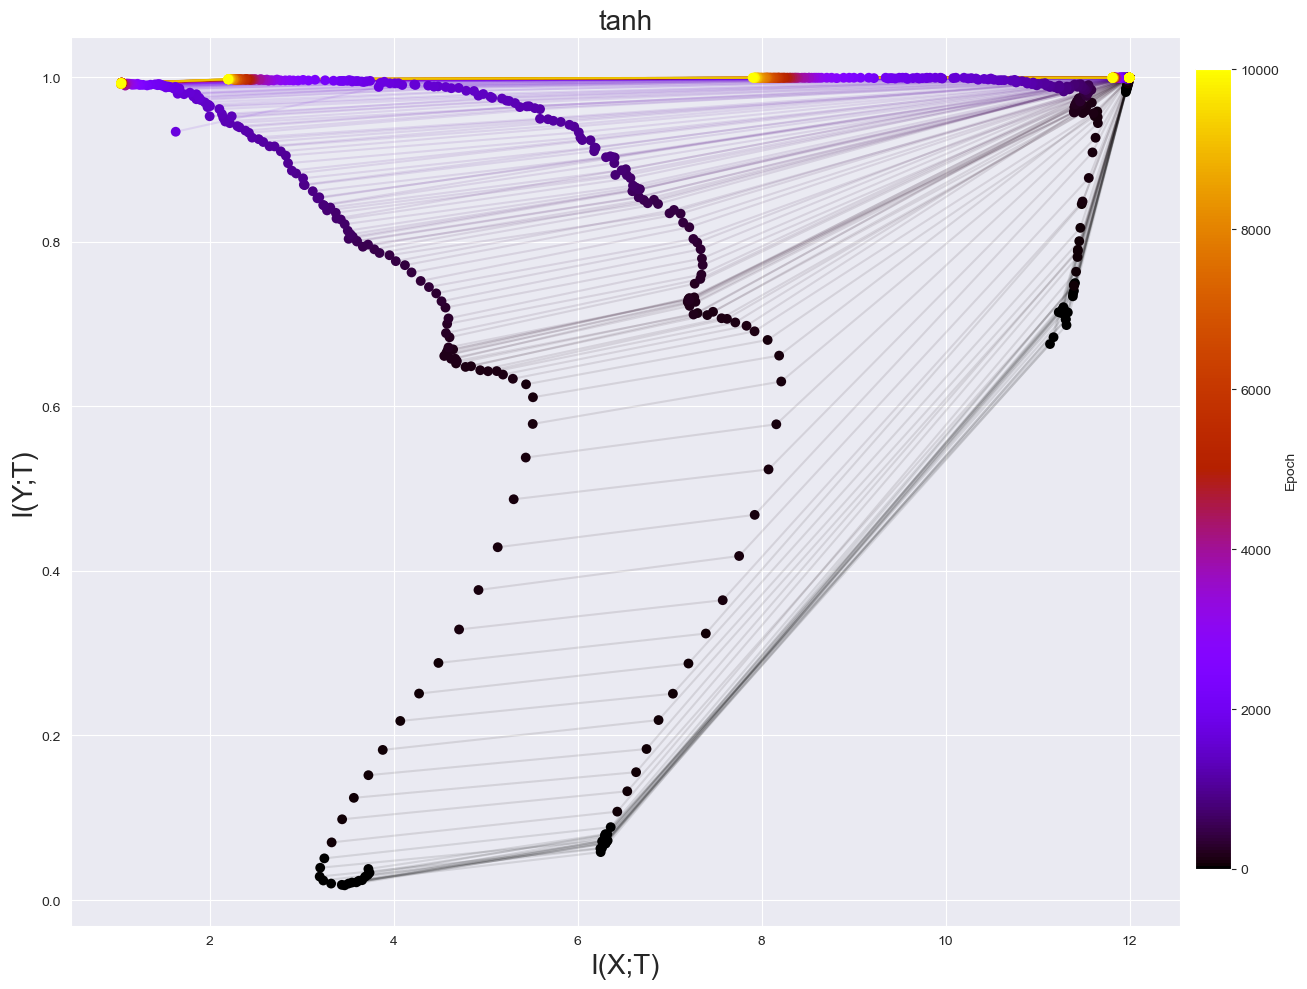

In [14]:
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
import seaborn as sns

infoplane_measure = 'bin'

max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(12,10))
for actndx, (activation, vals) in enumerate(measures.items()):
    
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    # plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]
        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=50, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)

    plt.xlabel('I(X;T)',fontsize=20)
    plt.ylabel('I(Y;T)',fontsize=20)
    plt.title(activation,fontsize=20)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()


DO_SAVE = False
if DO_SAVE:
    plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+activation+'_'+infoplane_measure),bbox_inches='tight')